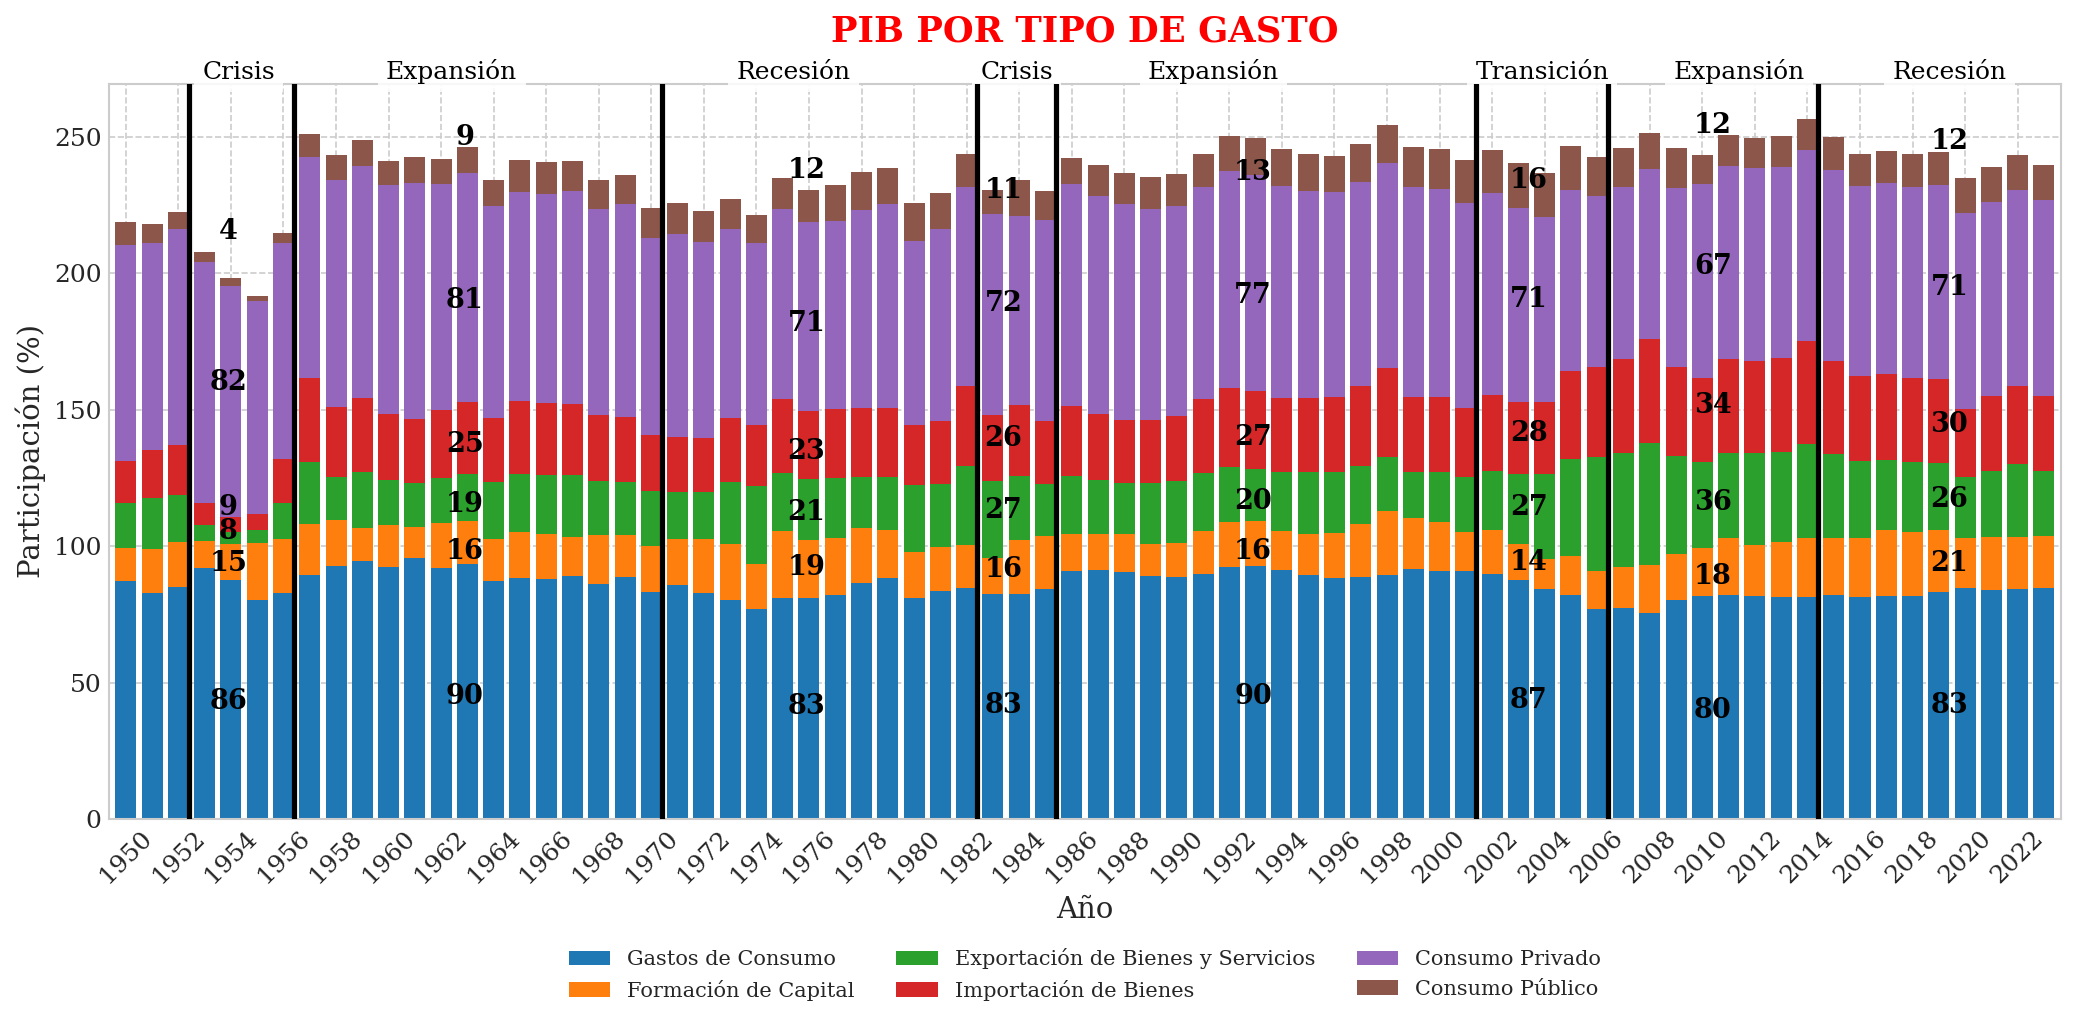

Imagen guardada en: ../../../../assets/tesis/serie_completa/pib/participacion_pib_gasto.png


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os
import numpy as np
from func_auxiliares.config import *
from func_auxiliares.graficos_utils import *


OUTPUT_DIR = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()
# ── 2. Carga de datos ───────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = pd.read_sql_query("SELECT * FROM PIB_Real_Gasto", conn)

df.set_index("año", inplace=True)
cycles_adj=adjust_cycles(df, CYCLES)

# ── 3. Selección de cols_cols_cols_componentes y cálculo de participaciones (%) ───────────
componentes = [
    ("gastos_consumo", "Gastos de Consumo"),
    ("formacion_capital", "Formación de Capital"),
    ("exportacion_bienes_servicios", "Exportación de Bienes y Servicios"),
    ("importacion_bienes", "Importación de Bienes"),
    ("consumo_privado", "Consumo Privado"),
    ("consumo_publico", "Consumo Público"),
]
cols = [
    'gastos_consumo',
    'formacion_capital', 
    'exportacion_bienes_servicios',
    'importacion_bienes',
    'consumo_privado',
    'consumo_publico'
]

#offset
# Extraer sólo esas columnas
comp = df[cols]

# Convertir a porcentaje del PIB real base 1990
pct = comp.div(df["pib_real_base_1990"], axis=0).multiply(100)

# Cálculo de estadísticas por ciclo
cycle_stats = {
    name: pct.loc[sl, cols].mean().to_dict()
    for name, sl in cycles_adj.items()
}

#offsets
hitos_offset = {
    1952: (0, 1),
    1956: (0, 1),
    1970: (0, 1),
    1982: (0, 1),
    1985: (0, 1),
    2001: (0, 1),
    2006: (0, 1),
    2014: (0, 1)
}
hitos_text_x = {
    1952: 1.9,
    1956: 6,
    1970: 5,
    1982: 1.5,
    1985: 6,
    2001: 2.5,
    2006: 5,
    2014: 5
}
hitos_offset = {
    1952: (0, 1),
    1956: (0, 1),
    1970: (0, 1),
    1982: (0, 1),
    1985: (0, 1),
    2001: (0, 1),
    2006: (0, 1),
    2014: (0, 1)
}

# Mapeo de colores acorde a tus otras gráficas
component_colors = [
    "#1f77b4",  # gastos_consumo
    "#ff7f0e",  # formacion_capital
    "#2ca02c",  # exportacion_bienes_servicios
    "#d62728",  # importacion_bienes
    "#9467bd",  # consumo_privado
    "#8c564b",  # consumo_publico
]

fig, ax = plot_stacked_bar(
    pct, 
    series=componentes,
    title="PIB POR TIPO DE GASTO",
    legend_ncol=3
)


MEAN_OFFSETS_BY_NAME = {
    "Crisis 52-55":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 56-69":   {'consumo_publico': (0.0, 14.5)},
    "Recesión 70-81":    {'consumo_publico': (0.0, 14.5)},
    "Crisis 82-85":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 86-99":   {'consumo_publico': (0.0, 15.0)},
    "Crisis 00-05":      {'consumo_publico': (0.0, 12.0)},
    "Expansión 06-14": {'consumo_publico': (0.0, 12.0)},
    "Recesión 15-23":    {'consumo_publico': (0.0, 12.0)},
}
# 2️⃣  Componentes cuyos promedios NO quieres anotar
SKIP_MEANS_BY_NAME = {
    "Crisis 52-55":      {'energia'},
    "Expansión 56-69":   {'energia'},
    "Recesión 70-81":    {'energia'},
    "Crisis 82-84":      {'energia'},
    "Expansión 85-00":   {'energia'},
    "Transicion 01-05":      {'energia'},
    "Expansión 06-14": {'energia'},
    "Recesión 15-23":    {'energia'},
}


add_hitos_barras(
    ax, df.index, hitos_v, hitos_offset, hitos_text_x
)
add_cycle_means_barras(
    ax,
    index=list(df.index),          # secuencia de años
    cycle_slices=cycles_adj,       # nombre → slice
    cycle_stats=cycle_stats,       # nombre → {col: media}
    cols=cols,                     # orden de apilado
    offsets=MEAN_OFFSETS_BY_NAME,  # opcional
    skip=SKIP_MEANS_BY_NAME        # opcional
)
# ── 6. Guardar y mostrar ───────────────────────────────────────────────────
plt.tight_layout()
out_path = os.path.join(OUTPUT_DIR, "participacion_pib_gasto.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Imagen guardada en: {out_path}")